In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import quandl
from stockAnalysisTools import numToString
from time import time

#### The cell below will be used to pull all the stock data we want and make a dictionary for accessing it

In [2]:
quandl.ApiConfig.api_key = "d1JcayaRuvKSaq7GaEHs"

In [3]:
import urllib.request, urllib.parse, urllib.error
from bs4 import BeautifulSoup
import ssl
import re

# Ignore SSL certificate errors
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
html = urllib.request.urlopen(url, context=ctx).read()
soup = BeautifulSoup(html, 'html.parser')

# soup
ticker_list = list()
for tag in soup('a'):
#     print(re.search(r'NyseSymbol|\S+}', soup))
    link = str(tag.get('href', None))
#     print(type(link))
    if "https://www.nyse.com/quote/XNYS" in link:
        ticker_list.append(link.rsplit(':')[-1])
    elif "http://www.nasdaq.com/symbol/" in link:
        ticker_list.append(link.rsplit('/')[-1])
    

# print(ticker_list)
# ticker_list.remove('QECx02')
# print(len(ticker_list))
ticker_list = list(map(lambda x: x.replace('.', '_') if '.' in x else x, ticker_list))
# ticker_list

In [73]:
startDate = '2001-07-01'
endDate = '2018-07-01'
finData = dict()
t0 = time()
print("Couldn't retrieve data for the stocks below, they may not have data available on Quandl.com, \
which is where the data is fetched from")
for ticker in ticker_list:
    flag = 0
    try:
        finData[ticker] = quandl.get("WIKI/"+ticker)["Adj. Close"].loc[startDate:endDate]
        flag = 1
    except:
        if flag == 0:
            print(ticker)
        
print("Run time:", round(time()-t0, 3)/60, "min")

EVRG
JEF
Run time: 1867.257 s


In [153]:
#     #All data will be normalized to start on the indecies of apple, so that when returns are calculated, the math can be done properly
aaplIndecies = finData["aapl"].index
    
def createRollingDF(key):
    rollingStat = finData[key].rolling(window=30,center=False).mean().dropna()
    rollingStd = finData[key].rolling(window=30,center=False).std().dropna()

    rollingStat = rollingStat.reset_index()

    rollingStat = rollingStat.rename(index=str, columns={"Adj. Close": "Rolling Mean"})
    rollingStat["Std"] = rollingStd.values
    rollingStat["Upper Band"] = rollingStat.apply(lambda row: row["Rolling Mean"] + 2*row["Std"], axis=1)
    rollingStat["Lower Band"] = rollingStat.apply(lambda row: row["Rolling Mean"] - 2*row["Std"], axis=1)

    rollingStat = rollingStat.set_index("Date")

    rollingStat["Adj. Close"] = finData[key]
    return rollingStat
    
def determineBuySell(df):
    df = df.reset_index()
    bd = df.apply(lambda row: (row["Rolling Mean"] - row["Adj. Close"])/row["Std"] \
                  if row["Adj. Close"] < row["Lower Band"] else 0, axis=1)
    sd = df.apply(lambda row: (row["Adj. Close"] - row["Rolling Mean"])/row["Std"] \
                  if row["Adj. Close"] > row["Upper Band"] else 0, axis=1)
 
    ret_df = pd.DataFrame()
    ret_df["Date"] = df["Date"]
    df = df.set_index("Date")
 
    ret_df["Position"] = bd + sd
    ret_df = ret_df.set_index("Date")
    ret_df["Buy Day"] = ret_df.apply(lambda row: 1 if row["Position"] > 0 else 0, axis=1)
    ret_df["Sell Day"] = ret_df.apply(lambda row: 1 if row["Position"] < 0 else 0, axis=1)
#     ret_df["Adj. Close"] = df["Adj. Close"]

    ret_df["Returns"] = df["Adj. Close"].pct_change().shift(-1).dropna()
#     ret_df["Returns"] = returns *  ret_df["Position"]
#     ret_df["Returns"] = ret_df["Returns"].dropna()
#     print(aaplIndecies)
    ret_df = ret_df.reindex(aaplIndecies)
    ret_df = ret_df.fillna(0)
    ret_df["Returns"][-1] = np.nan
    return ret_df
    

In [94]:
rollingDFs = dict()
t0 = time()
keys_to_rm = list()
for key in finData.keys():
    flag = 0
    try:
        rollingDFs[key] = createRollingDF(key)
        flag = 1
    except:
        if flag == 0:
            keys_to_rm.append(key)
            
print("Run time:", round(time()-t0, 3)/60, "min")

#Keys for some stocks end up getting removed because they cause errors due to
#not enough market data being available to calculate a rolling stat over a 30 day period
print("Couldn't calculate rolling data for the stocks below, so they are being removed from the findData dictionary:")
for key in keys_to_rm:
    print(key)
#     finData.pop(key, None)

Run time: 8.3409 min
Couldn't calculate rolling data for the stocks below, so they are being removed from the findData dictionary:


In [154]:
returnsDFs = dict()
t0 = time()
keys_to_rm = list()
for key in rollingDFs.keys():
    flag = 0
    try:
        returnsDFs[key] = determineBuySell(rollingDFs[key])
        flag = 1
    except:
        if flag == 0:
            keys_to_rm.append(key)
            
print("Run time:", round(time()-t0, 3)/60, "min")

#Keys for some stocks end up getting removed because they cause errors due to
#not enough market data being available to calculate a rolling stat over a 30 day period
print("Couldn't calculate return data for the stocks below, so they are being removed from the findData dictionary:")
for key in keys_to_rm:
    print(key)
    finData.pop(key, None)

Run time: 9.152566666666667 min
Couldn't calculate return data for the stocks below, so they are being removed from the findData dictionary:


In [173]:
dates = dict()
comparison_df = pd.DataFrame()
flag = True
t0 = time()
for key in returnsDFs.keys():
#     print(key)
#     print(returnsDFs[key])
#     break
    if flag is True:
        comparison_df = returnsDFs[key]["Position"].to_frame()
        comparison_df = comparison_df.rename(index=str, columns={"Position": key})
        flag = False 
    else:
#         print(key)
        comparison_df[key] = returnsDFs[key]["Position"]
#         print(comparison_df)
#         print(returnsDFs[key]["Position"].cumsum())
#         break
#         comparison_df = pd.merge(left = comparison_df, right = returnsDFs[key]["Position"].to_frame(), how = 'inner', on = "Date")
#         comparison_df
#         break

comparison_df.fillna(0)
print("Run time:", round(time()-t0, 3), "s")

t0 = time()
transpose_df = comparison_df.T
for date in transpose_df:
    dates[date] = transpose_df[date].nlargest(50).index.tolist()
print("Run time:", round(time()-t0, 3), "s")
# print(dates)

Run time: 1.492 s
Run time: 6.094 s


In [188]:
def determineTop50(df, key):
    df = df.reset_index()
    df["Position"] = df.apply(lambda row: row["Buy Day"] + (-1*row["Sell Day"]) if key in dates[str(row["Date"])] else 0,  axis=1)
    df = df.set_index("Date")
    return df["Position"]

In [189]:
t0 = time()
for key in returnsDFs.keys():
    returnsDFs[key]["Position"] = determineTop50(returnsDFs[key], key)
print("Run time:", round(time()-t0, 3)/60, "min")

Run time: 4.649683333333333 min


In [191]:
t0 = time()
flag = True
for key in returnsDFs.keys():
    d = returnsDFs[key]
    if flag is True:
        ret = d["Position"] * d["Returns"]
        flag = False
    else:
        ret += d["Position"] * d["Returns"]
        
print("Run time:", round(time()-t0, 3), "s")

Run time: 0.206 s


## Sharpe Calculated

In [193]:
ret.mean()/ret.std()

0.03151458791930259

## Beta Calculated

In [227]:
sp500 = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH").loc[startDate:endDate]

In [216]:
ret.corr(sp500["Value"])

-0.44194293139257651

In [2]:
aapl = "aapl"
goog  = "goog"
stockList = [aapl, goog]
finData = dict()

for ticker in stockList:
    finData[ticker] = quandl.get("WIKI/"+ticker)["Adj. Close"]

In [66]:
class Stock(object):
    
    def __init__(self, name):
        self.name = name
        self.percentage = 0.0
        
    def set_portfolio_percentage(self, val):
        self.percentage = val/100.0
#         if val > 100.0 or val < 0.0:
#             print("Invalid value. A stock can only occupy between 0 - 100 percent of a portfolio")
#         else:
#             self.percentage = val/100.0\

        
            

In [68]:
class Portfolio(object):
    stocks = list()
    uninvestedMoney = 0
    
    def addStock(self, stock):
        
        if(stock.name not in finData.keys()):
            print("We haven't pulled up data for this stock, so it can't be added")
            return
        
        self.stocks.append(stock)
    
    def addMoney(self, money):
        
        self.uninvestedMoney += money
        
    def reset(self):
        self.uninvestedMoney = 0
        if len(self.stocks) != 0:
            self.stocks = []
            
    def validity_check(self):
        sum_of_percentage = 0.0
        for stock in self.stocks:
            sum_of_percentage += stock.percentage
            
        if(sum_of_percentage == 1):
            return True
        else:
            return False

#### Creating Portfolio

In [69]:
my_portfolio = Portfolio()
my_portfolio.addMoney(100)
aapl = Stock("aapl")
aapl.set_portfolio_percentage(50)
goog = Stock("goog")
goog.set_portfolio_percentage(50)
my_portfolio.addStock(aapl)
my_portfolio.addStock(goog)

if my_portfolio.validity_check():
    print("Portfolio Valid")
else:
    print("Not Valid")

Portfolio Valid


#### Simple Trading Strategy per 30 days

In [39]:
startDate = '2001-07-01'
endDate = '2018-07-01'

aaplReturn = finData[aapl.name].loc[startDate: endDate].pct_change().shift(-1).dropna()
aaplSharpe = aaplReturn.mean()/aaplReturn.std()
aaplRollingStat = finData[aapl.name].loc[startDate: endDate].rolling(window=30,center=False).mean().dropna()
aaplRollingStd = finData[aapl.name].loc[startDate: endDate].rolling(window=30,center=False).std().dropna()

aaplRollingStat = aaplRollingStat.reset_index()

aaplRollingStat = aaplRollingStat.rename(index=str, columns={"Adj. Close": "Rolling Mean"})
aaplRollingStat["Std"] = aaplRollingStd.values
aaplRollingStat["Upper Band"] = aaplRollingStat.apply(lambda row: row["Rolling Mean"] + 2*row["Std"], axis=1)
aaplRollingStat["Lower Band"] = aaplRollingStat.apply(lambda row: row["Rolling Mean"] - 2*row["Std"], axis=1)

aaplRollingStat = aaplRollingStat.set_index("Date")

aaplRollingStat["Adj. Close"] = finData[aapl.name].loc[aaplRollingStat.index[0]:aaplRollingStat.index[-1]].values

In [40]:
startDate = '2001-07-01'
endDate = '2018-07-01'

googReturn = finData[goog.name].loc[startDate: endDate].pct_change().shift(-1).dropna()
googSharpe = googReturn.mean()/googReturn.std()
googRollingStat = finData[goog.name].loc[startDate: endDate].rolling(window=30,center=False).mean().dropna()
googRollingStd = finData[goog.name].loc[startDate: endDate].rolling(window=30,center=False).std().dropna()

googRollingStat = googRollingStat.reset_index()

googRollingStat = googRollingStat.rename(index=str, columns={"Adj. Close": "Rolling Mean"})
googRollingStat["Std"] = googRollingStd.values
googRollingStat["Upper Band"] = googRollingStat.apply(lambda row: row["Rolling Mean"] + 2*row["Std"], axis=1)
googRollingStat["Lower Band"] = googRollingStat.apply(lambda row: row["Rolling Mean"] - 2*row["Std"], axis=1)

googRollingStat = googRollingStat.set_index("Date")

googRollingStat["Adj. Close"] = finData[goog.name].loc[googRollingStat.index[0]:googRollingStat.index[-1]].values

## Stratagey In Practice

##### Longs only

In [54]:
aaplRollingStat = aaplRollingStat.reset_index()

aaplRollingStat["Buy Day"] = aaplRollingStat.apply(lambda row: 1 if row["Adj. Close"] < row["Lower Band"] else 0, axis=1)
aaplRollingStat["Sell Day"] = aaplRollingStat.apply(lambda row: 1 if row["Adj. Close"] > row["Upper Band"] else 0, axis=1)
    

aaplRollingStat = aaplRollingStat.set_index("Date")


return_aapl = pd.DataFrame()
return_aapl["Position"] =aaplRollingStat["Buy Day"]
return_aapl["Adj. Close"] = aaplRollingStat["Adj. Close"]

return_aapl["Returns"] = aaplReturn *  return_aapl["Position"]
return_aapl["Returns"] = return_aapl["Returns"].dropna()

In [55]:
googRollingStat = googRollingStat.reset_index()

googRollingStat["Buy Day"] = googRollingStat.apply(lambda row: 1 if row["Adj. Close"] < row["Lower Band"] else 0, axis=1)
googRollingStat["Sell Day"] = googRollingStat.apply(lambda row: 1 if row["Adj. Close"] > row["Upper Band"] else 0, axis=1)
    

googRollingStat = googRollingStat.set_index("Date")


return_goog = pd.DataFrame()
return_goog["Position"] =googRollingStat["Buy Day"]
return_goog["Adj. Close"] = googRollingStat["Adj. Close"]

return_goog["Returns"] = googReturn *  return_goog["Position"]
return_goog["Returns"] = return_goog["Returns"].dropna()

#Done to match aapl's data
return_goog = return_goog.reindex(return_aapl.index)
return_goog["Returns"] = return_goog["Returns"].replace(np.nan, 0)
return_goog["Returns"][-1] = np.nan

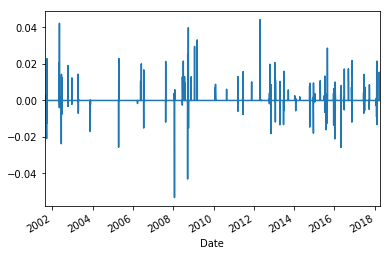

Percent return of the portfolio:  1.60321389529
Sharpe of this stratagey: 0.037442399544633034


In [56]:
returns = (return_aapl["Returns"]*aapl.percentage) + (return_goog["Returns"]*goog.percentage)
ret_plt =  returns.plot()
plt.show()

list_of_returns = list()
list_of_returns.append(((1+return_aapl["Returns"]).dropna()).cumprod()[-1])
list_of_returns.append(((1+return_goog["Returns"]).dropna()).cumprod()[-1])
print("Percent return of the portfolio: ", sum(list_of_returns)/len(list_of_returns))

ret_sharpe = returns.mean()/returns.std()
print("Sharpe of this stratagey:", ret_sharpe)

##### Shorts and Longs

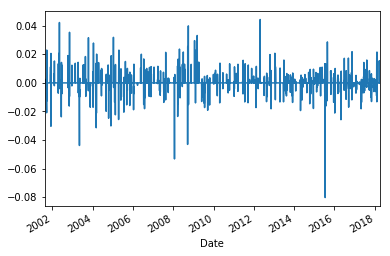

Percent return of the portfolio:  0.959386028284
Sharpe of this stratagey: 0.0014593536878933062


In [57]:
aaplRollingStat = aaplRollingStat.reset_index()

aaplRollingStat["Buy Day"] = aaplRollingStat.apply(lambda row: 1 if row["Adj. Close"] < row["Lower Band"] else 0, axis=1)
aaplRollingStat["Sell Day"] = aaplRollingStat.apply(lambda row: 1 if row["Adj. Close"] > row["Upper Band"] else 0, axis=1)
    

aaplRollingStat = aaplRollingStat.set_index("Date")


return_aapl = pd.DataFrame()
return_aapl["Position"] = aaplRollingStat["Buy Day"] + (-1*aaplRollingStat["Sell Day"])
return_aapl["Adj. Close"] = aaplRollingStat["Adj. Close"]

return_aapl["Returns"] = aaplReturn *  return_aapl["Position"]
return_aapl["Returns"] = return_aapl["Returns"].dropna()

googRollingStat = googRollingStat.reset_index()

googRollingStat["Buy Day"] = googRollingStat.apply(lambda row: 1 if row["Adj. Close"] < row["Lower Band"] else 0, axis=1)
googRollingStat["Sell Day"] = googRollingStat.apply(lambda row: 1 if row["Adj. Close"] > row["Upper Band"] else 0, axis=1)
    

googRollingStat = googRollingStat.set_index("Date")


return_goog = pd.DataFrame()
return_goog["Position"] =googRollingStat["Buy Day"] + (-1*googRollingStat["Sell Day"])
return_goog["Adj. Close"] = googRollingStat["Adj. Close"]

return_goog["Returns"] = googReturn *  return_goog["Position"]
return_goog["Returns"] = return_goog["Returns"].dropna()

#Done to match aapl's data
return_goog = return_goog.reindex(return_aapl.index)
return_goog["Returns"] = return_goog["Returns"].replace(np.nan, 0)
return_goog["Returns"][-1] = np.nan

returns = (return_aapl["Returns"]*aapl.percentage) + (return_goog["Returns"]*goog.percentage)
ret_plt =  returns.plot()
plt.show()

list_of_returns = list()
list_of_returns.append(((1+return_aapl["Returns"]).dropna()).cumprod()[-1])
list_of_returns.append(((1+return_goog["Returns"]).dropna()).cumprod()[-1])
print("Percent return of the portfolio: ", sum(list_of_returns)/len(list_of_returns))

ret_sharpe = returns.mean()/returns.std()
print("Sharpe of this stratagey:", ret_sharpe)